In [1]:
import sys
import os

# Thêm đường dẫn vào sys.path
sys.path.append('/kaggle/input/resfusionmodel')

In [2]:
import sys
sys.argv = sys.argv[:1]  # Loại bỏ đối số '-f' của Jupyter

In [ ]:
# # https://github.com/IGITUGraz/WeatherDiffusion
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.transforms import Normalize
import numpy as np
import pytorch_lightning as pl




##################################################################
#train_transform = A.Compose([
#     A.RandomCrop(height=256, width=256),
#     A.HorizontalFlip(p=0.5),
#     Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
#     ToTensorV2()],
#     additional_targets={'gt_image': 'image'},
# )

# test_transform = A.Compose([
#     Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
#     ToTensorV2()],
#     additional_targets={'gt_image': 'image'},
# )
##################################################################

import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    # Random cropping to focus on different regions
    #A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.5),
    A.RandomCrop(height=256, width=256),
    # Horizontal & Vertical Flip to generalize better
    A.HorizontalFlip(p=0.5),
    #A.VerticalFlip(p=0.2),
    
    # Apply motion blur to simulate realistic rain streaks
    #A.MotionBlur(blur_limit=5, p=0.2),
    
    # Gaussian blur to remove sharp artificial boundaries
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    
    # Random brightness and contrast adjustments to account for lighting changes
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    
    # Apply color jittering to increase generalization
    #A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3),
    
    # Random shadow simulation (useful for handling raindrop occlusions)
    #A.RandomShadow(p=0.2),
    
    # Random scale transforms to introduce slight perspective distortions
    #A.Affine(scale=(0.9, 1.1), translate_percent=(0.05, 0.05), rotate=(-5, 5), p=0.2),
    
    # Normalization and conversion to tensor
    Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
    ToTensorV2()
], additional_targets={'gt_image': 'image'})

test_transform = A.Compose([
    #A.Resize(height=256, width=256),
    Normalize(mean=(0, 0, 0), std=(1, 1, 1)),

    # Keep test data clean but normalize it properly
    #A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
], additional_targets={'gt_image': 'image'})


class RaindropDataset(Dataset):
    def __init__(self, root_dir, subset_day="DayRainDrop_Train_img/DayRainDrop_Train", subset_night="NightRainDrop_Train_img/NightRainDrop_Train", transform=None):
        """
        Initialize the dataset.
        :param root_dir: Root directory of the dataset
        :param subset_day: Path to the daytime dataset
        :param subset_night: Path to the nighttime dataset
        :param transform: Transformations to apply to the data
        """
        self.root_dir = root_dir
        self.transform = transform

        # Daytime paths
        subset_path_day = os.path.join(root_dir, subset_day)
        drop_path_day = os.path.join(subset_path_day, "Drop")
        clear_path_day = os.path.join(subset_path_day, "Clear")

        if os.path.exists(drop_path_day) and os.path.exists(clear_path_day):
            self.img_dir_day = drop_path_day
            self.gt_dir_day = clear_path_day
            self.img_names_day = sorted(os.listdir(drop_path_day))
            self.gt_names_day = sorted(os.listdir(clear_path_day))
        else:
            self.img_dir_day, self.gt_dir_day, self.img_names_day, self.gt_names_day = None, None, [], []

        # Nighttime paths
        subset_path_night = os.path.join(root_dir, subset_night)
        drop_path_night = os.path.join(subset_path_night, "Drop")
        clear_path_night = os.path.join(subset_path_night, "Clear")

        if os.path.exists(drop_path_night) and os.path.exists(clear_path_night):
            self.img_dir_night = drop_path_night
            self.gt_dir_night = clear_path_night
            self.img_names_night = sorted(os.listdir(drop_path_night))
            self.gt_names_night = sorted(os.listdir(clear_path_night))
        else:
            self.img_dir_night, self.gt_dir_night, self.img_names_night, self.gt_names_night = None, None, [], []

        # Combine both datasets
        self.img_names = self.img_names_day + self.img_names_night
        self.gt_names = self.gt_names_day + self.gt_names_night
        self.img_dirs = [self.img_dir_day] * len(self.img_names_day) + [self.img_dir_night] * len(self.img_names_night)
        self.gt_dirs = [self.gt_dir_day] * len(self.gt_names_day) + [self.gt_dir_night] * len(self.gt_names_night)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_dir = self.img_dirs[idx]
        gt_name = self.gt_names[idx]
        gt_dir = self.gt_dirs[idx]

        img_path = os.path.join(img_dir, img_name)
        gt_path = os.path.join(gt_dir, gt_name)

        image = Image.open(img_path).convert("RGB")
        gt = Image.open(gt_path).convert("RGB")

        # Resize images to be multiples of 16 for whole-image restoration
        wd_new, ht_new = image.size
        if ht_new > wd_new and ht_new > 1024:
            wd_new = int(np.ceil(wd_new * 1024 / ht_new))
            ht_new = 1024
        elif ht_new <= wd_new and wd_new > 1024:
            ht_new = int(np.ceil(ht_new * 1024 / wd_new))
            wd_new = 1024
        wd_new = int(16 * np.ceil(wd_new / 16.0))
        ht_new = int(16 * np.ceil(ht_new / 16.0))

        image = image.resize((wd_new, ht_new))
        gt = gt.resize((wd_new, ht_new))

        # Convert PIL images to NumPy arrays
        image = np.array(image)
        gt = np.array(gt)

        if self.transform:
            augmented = self.transform(image=image, gt_image=gt)
            image = augmented['image']
            gt = augmented['gt_image']

        return image, gt


import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, random_split

class RaindropDataModule(pl.LightningDataModule):
    def __init__(self, root_dir: str = "kaggle/input/ntire2025", batch_size=1, pin_mem=True, num_workers=4):
        super().__init__()
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.pin_mem = pin_mem
        self.num_workers = num_workers

    def setup(self, stage: str):
        if stage == "fit" or stage == 'validate' or stage is None:
            full_train_dataset = RaindropDataset(root_dir=self.root_dir, transform=train_transform)

            # Split dataset: 90% train, 10% validation
            train_size = int(0.9 * len(full_train_dataset))
            val_size = len(full_train_dataset) - train_size
            self.train_dataset, self.val_dataset = random_split(full_train_dataset, [train_size, val_size])

        if stage == "test":
            self.test_dataset = RaindropDataset(root_dir=self.root_dir, subset="Rain_Valid_TRUE", transform=test_transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=True,
                          pin_memory=self.pin_mem, num_workers=self.num_workers, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=1, shuffle=False, drop_last=False,
                          pin_memory=self.pin_mem, num_workers=self.num_workers, persistent_workers=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=1, shuffle=False, drop_last=False,
                          pin_memory=self.pin_mem, num_workers=self.num_workers, persistent_workers=True)




/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
# import os
# import torch
# from torch.utils.data import Dataset
# from PIL import Image
# import matplotlib.pyplot as plt
# import albumentations as A
# from albumentations.pytorch.transforms import ToTensorV2
# from albumentations.augmentations.transforms import Normalize
# import numpy as np
# import pytorch_lightning as pl

# # def visualize(image, mask, original_image=None, original_gt=None):
# #     fontsize = 18
# #
# #     if original_image is None and original_gt is None:
# #         f, ax = plt.subplots(2, 1, figsize=(8, 8))
# #         ax[0].imshow(image)
# #         ax[1].imshow(mask)
# #     else:
# #         f, ax = plt.subplots(2, 2, figsize=(8, 8))
# #
# #         ax[0, 0].imshow(original_image)
# #         ax[0, 0].set_title('Original image', fontsize=fontsize)
# #
# #         ax[1, 0].imshow(original_gt)
# #         ax[1, 0].set_title('Original gt', fontsize=fontsize)
# #
# #         ax[0, 1].imshow(image)
# #         ax[0, 1].set_title('Transformed image', fontsize=fontsize)
# #
# #         ax[1, 1].imshow(mask)
# #         ax[1, 1].set_title('Transformed gt', fontsize=fontsize)


# ##################################################################
# train_transform = A.Compose([
#     A.RandomCrop(height=256, width=256),
#     A.HorizontalFlip(p=0.5),
#     Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
#     ToTensorV2()],
#     additional_targets={'gt_image': 'image'},
# )

# test_transform = A.Compose([
#     Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
#     ToTensorV2()],
#     additional_targets={'gt_image': 'image'},
# )
# ##################################################################


# class RaindropDataset(Dataset):
#     def __init__(self, root_dir, subset="train_set", transform=None):
#         """
#         初始化函数
#         :param root_dir: 数据集的根目录
#         :param subset: 使用的数据子集 ('train', 'test_a')
#         :param transform: 应用于数据的转换
#         """
#         self.root_dir = root_dir
#         self.subset = subset
#         self.transform = transform
#         self.img_dir = os.path.join(root_dir, subset, "raindrop")
#         self.gt_dir = os.path.join(root_dir, subset, "gt")
#         self.img_names = os.listdir(self.img_dir)
#         self.img_names.sort()
#         self.gt_names = os.listdir(self.gt_dir)
#         self.gt_names.sort()
#     def __len__(self):
#         return len(self.img_names)

#     def __getitem__(self, idx):
#         img_name = self.img_names[idx]
#         gt_name = self.gt_names[idx]
        
#         img_path = os.path.join(self.img_dir, img_name)
#         gt_path = os.path.join(self.gt_dir, gt_name)
#         # 读取图像
#         image = Image.open(img_path).convert("RGB")
#         gt = Image.open(gt_path).convert("RGB")
#         # Resizing images to multiples of 16 for whole-image restoration
#         wd_new, ht_new = image.size
#         if ht_new > wd_new and ht_new > 1024:
#             wd_new = int(np.ceil(wd_new * 1024 / ht_new))
#             ht_new = 1024
#         elif ht_new <= wd_new and wd_new > 1024:
#             ht_new = int(np.ceil(ht_new * 1024 / wd_new))
#             wd_new = 1024
#         wd_new = int(16 * np.ceil(wd_new / 16.0))
#         ht_new = int(16 * np.ceil(ht_new / 16.0))
#         image = image.resize((wd_new, ht_new))
#         gt = gt.resize((wd_new, ht_new))
#         # 将PIL图像转换为NumPy数组
#         image = np.array(image)
#         gt = np.array(gt)
#         if self.transform:
#             augmented = self.transform(image=image, gt_image=gt)
#             image = augmented['image']
#             gt = augmented['gt_image']
#         img_input = image
#         target = gt
#         return img_input, target


# class RaindropDataModule(pl.LightningDataModule):
#     def __init__(self, root_dir: str = "/kaggle/input/addition-dataset-rain/RainDS/RainDS_real", batch_size=1, pin_mem=True, num_workers=4):
#         super().__init__()
#         self.root_dir = root_dir
#         self.batch_size = batch_size
#         self.pin_mem = pin_mem
#         self.num_workers = num_workers

#     '''
#     setup 方法创建Dataset对象，对不同数据集指定预处理方法
#     '''

#     def setup(self, stage: str):
#         # Assign train/val dataloader for use in dataloaders
#         if stage == "fit":
#             self.train_dataset = RaindropDataset(root_dir=self.root_dir, subset="train_set", transform=train_transform)
#             self.val_dataset = RaindropDataset(root_dir=self.root_dir, subset="test_set", transform=test_transform)
#         # Assign test dataset for use in dataloader(s)
#         if stage == "validate":
#             self.val_dataset = RaindropDataset(root_dir=self.root_dir, subset="test_set", transform=test_transform)
#         if stage == "test":
#             self.test_dataset = RaindropDataset(root_dir=self.root_dir, subset="test_set", transform=test_transform)

#     # 以下方法创建不同阶段的数据加载器
#     def train_dataloader(self):
#         return torch.utils.data.DataLoader(self.train_dataset, shuffle=True, drop_last=True,
#                                            batch_size=self.batch_size, pin_memory=self.pin_mem,
#                                            num_workers=self.num_workers, persistent_workers=True)

#     # batch_size must be 1 because size is different
#     def val_dataloader(self):
#         return torch.utils.data.DataLoader(self.val_dataset, shuffle=False, drop_last=False,
#                                            batch_size=1, pin_memory=self.pin_mem,
#                                            num_workers=self.num_workers, persistent_workers=True)

#     # batch_size must be 1 because size is different
#     def test_dataloader(self):
#         return torch.utils.data.DataLoader(self.test_dataset, shuffle=False, drop_last=False,
#                                            batch_size=1, pin_memory=self.pin_mem,
#                                            num_workers=self.num_workers, persistent_workers=True)

# # # test code
# # if __name__ == '__main__':
# #     my_dataset = RainDropDataset(root_dir='../../datasets/Raindrop')
# #     input, target = my_dataset.__getitem__(0)
# #
# #     # 展示图像和掩码
# #     visualize(input, target)
# #     plt.show()


13368


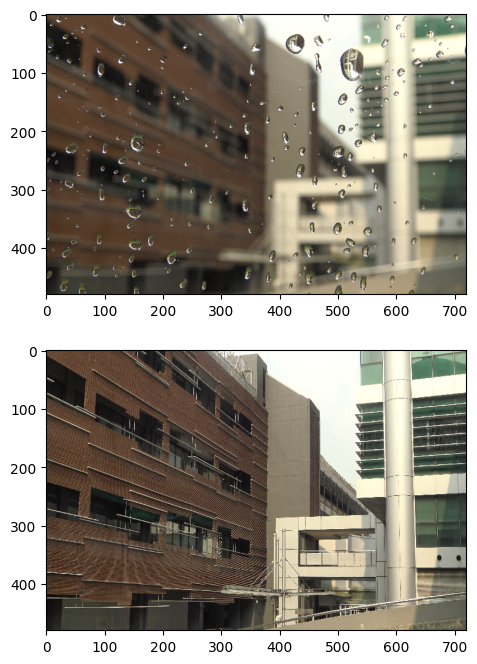

In [ ]:
def visualize(image, mask, original_image=None, original_gt=None):
    fontsize = 18

    if original_image is None and original_gt is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))
        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)

        ax[1, 0].imshow(original_gt)
        ax[1, 0].set_title('Original gt', fontsize=fontsize)

        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)

        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed gt', fontsize=fontsize)
        
my_dataset = RaindropDataset(root_dir='kaggle/input/ntire2025')
input, target = my_dataset.__getitem__(1)

print(len(my_dataset))
# 展示图像和掩码
visualize(input, target)
plt.show()

In [6]:
from typing import Callable, Iterator, Tuple, Optional, Type, Union, List, ClassVar

import pytorch_lightning as pl
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from torch.nn import functional as F

from model.distributions import resfusion_x0_to_xt, ddpm_x0_to_xt
from variance_scheduler.abs_var_scheduler import Scheduler
from torch import optim
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure


class GaussianResfusion_Restore(pl.LightningModule):
    """
    Gaussian Prior Residual Noise embedded De-noising Diffusion Probabilistic Model
    """

    def __init__(self, denoising_module: pl.LightningModule, variance_scheduler: Scheduler,
                 mode='epsilon',
                 loss_type='L2', optimizer_type='Adam', lr_scheduler_type='CosineAnnealingLR', **kwargs):
        """
        :param denoising_module: the nn which computes the denoise step i.e. q(x_{t-1} | x_t, x_0, R)
        :param variance_scheduler: the variance scheduler cited in DDPM paper. See folder variance_scheduler
        :param mode: 'epsilon' or 'sample' or 'residual'
        """
        super().__init__()
        # lightning code
        self.save_hyperparameters(ignore=['denoising_module', 'variance_scheduler'])
        # sample mode
        self.mode = mode
        # loss type
        self.loss_type = loss_type
        # optimizer type
        self.optimizer_type = optimizer_type
        # lr_scheduler type
        self.lr_scheduler_type = lr_scheduler_type
        # initialize models
        self.denoising_module = denoising_module

        # PSNR
        self.val_PSNR = PeakSignalNoiseRatio(dim=(1, 2, 3), data_range=(0, 1))
        self.test_PSNR = PeakSignalNoiseRatio(dim=(1, 2, 3), data_range=(0, 1))
        self.val_SSIM = StructuralSimilarityIndexMeasure(data_range=(0, 1))
        self.test_SSIM = StructuralSimilarityIndexMeasure(data_range=(0, 1))

        # get the variance scheduler cited in DDPM paper
        self.var_scheduler = variance_scheduler
        self.alphas_hat = self.var_scheduler.get_alphas_hat()
        self.alphas = self.var_scheduler.get_alphas()
        self.betas = self.var_scheduler.get_betas()
        self.betas_hat = self.var_scheduler.get_betas_hat()
        self.alphas_hat_t_minus_1 = self.var_scheduler.get_alphas_hat_t_minus_1()
        # acc point
        self.T_acc = self.get_acc_point(self.alphas_hat).item()
        print('acc point:', self.T_acc)

    def get_acc_point(self, alphas_hat):
        """
            Calculate Acceleration Point, according to formula 27
        """
        abs_dist = torch.abs(torch.sqrt(alphas_hat) - 0.5)
        return abs_dist.argmin() + 1

    def forward(self, x_t: torch.FloatTensor, I_in: torch.FloatTensor, t: int) -> torch.Tensor:
        """
        Forward pass of the Resfusion model.

        Args:
            x_t: noised Input image tensor.
            I_in: condition image tensor.
            t: Time step tensor.

        Returns:
            predicted noise tensor or predicted x_0 tensor.
        """
        return self.denoising_module(x_t, I_in, t)

    def training_step(self, batch, batch_idx: int):
        """
        Training step of the Resfusion model.

        Args:
            batch:
                input: normalized degraded picture, [0, 1]
                target: normalized ground truth picture, [0, 1]
            batch_idx: Batch index.

        Returns:
            loss.
        """
        inputs, targets = batch
        # initialize X_0 and X_0_hat
        X_0 = targets
        X_0_hat = inputs
        # Map image values from [0, 1] to [-1, 1]
        X_0 = X_0 * 2 - 1
        X_0_hat = X_0_hat * 2 - 1
        # Compute the residual term following formula 16
        residual_term = X_0_hat - X_0
        # Sample a random time step t from 0 to T_acc-1 for each image in the batch
        # Uniform Sampling
        t: torch.Tensor = torch.randint(0, self.T_acc, (X_0.shape[0],), device=self.device)
        # Compute alpha_hat for the selected time steps
        alpha_hat = self.alphas_hat[t].reshape(-1, 1, 1, 1)
        # Sample noise from a normal distribution with the same shape as X_0
        noise = torch.randn_like(X_0)
        # Compute the intermediate image x_t from the original image X_0, alpha_hat, residual term and noise
        x_t = resfusion_x0_to_xt(X_0, alpha_hat, residual_term, noise)  # go from x_0 to x_t with the formula 20
        if self.mode == 'epsilon':
            # Compute alpha, beta for the selected time steps
            alpha = self.alphas[t].reshape(-1, 1, 1, 1)
            beta = self.betas[t].reshape(-1, 1, 1, 1)
            # Compute resnoise with formula 24
            resnoise = noise + (1 - torch.sqrt(alpha)) * torch.sqrt(1 - alpha_hat) / beta * residual_term
            # Run the intermediate image x_t through the model to obtain predicted resnoise
            pred_resnoise = self.denoising_module(x=x_t, time=t, input_cond=X_0_hat)
            # Loss
            if self.loss_type == 'L2':
                # Compute the MSE loss for the predicted noise
                loss = F.mse_loss(input=pred_resnoise, target=resnoise)
            elif self.loss_type == 'L1':
                # Compute the smooth L1 loss for the predicted noise
                loss = F.smooth_l1_loss(input=pred_resnoise, target=resnoise)
            else:
                raise ValueError("Wrong loss type !!!")
        elif self.mode == 'sample':
            # Run the intermediate image x_t through the model to obtain predicted x_0
            pred_x_0 = self.denoising_module(x=x_t, time=t, input_cond=X_0_hat)
            # Loss
            if self.loss_type == 'L2':
                # Compute the MSE loss for the predicted x_0
                loss = F.mse_loss(input=pred_x_0, target=X_0)
            elif self.loss_type == 'L1':
                # Compute the smooth L1 loss for the predicted noise
                loss = F.smooth_l1_loss(input=pred_x_0, target=X_0)
            else:
                raise ValueError("Wrong loss type !!!")
        elif self.mode == 'residual':
            # Run the intermediate image x_t through the model to obtain predicted residual_term
            pred_residual_term = self.denoising_module(x=x_t, time=t, input_cond=X_0_hat)
            # Loss
            if self.loss_type == 'L2':
                # Compute the MSE loss for the predicted x_0
                loss = F.mse_loss(input=pred_residual_term, target=residual_term)
            elif self.loss_type == 'L1':
                # Compute the smooth L1 loss for the predicted noise
                loss = F.smooth_l1_loss(input=pred_residual_term, target=residual_term)
        else:
            raise ValueError("Wrong mode !!!")
        self.log('train_loss', loss, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx: int):
        inputs, targets = batch
        X_0 = targets
        X_0_hat = inputs
        # Map image values from [0, 1] to [-1, 1]
        X_0_hat = X_0_hat * 2 - 1
        pred_x_0 = self.generate(X_0_hat)
        # threshold clip
        pred_x_0 = torch.clamp(pred_x_0, min=-1, max=1)
        # rescale from [-1, 1] to [0, 1]
        pred_x_0 = (pred_x_0 + 1) / 2
        
        # calculate PSNR
        val_psnr=self.val_PSNR(preds=pred_x_0, target=X_0)
        self.log('val_PSNR', self.val_PSNR, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        
        # calculate SSIM
        val_ssim = self.val_SSIM(preds=pred_x_0, target=X_0)
        self.log('val_SSIM', self.val_SSIM, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)

        # print combined score
        
        score = val_psnr + 10 * val_ssim
        if batch_idx %100 ==0:
            print(f"Step {batch_idx}: Score = {score:.4f}, PSNR {val_psnr}, SSIM {val_ssim}")
        
        # log images
        if batch_idx < 4:
            self.log_tb_images((inputs, targets, pred_x_0), batch_idx, self.current_epoch, save_all=False)


    def test_step(self, batch, batch_idx: int):
        inputs, targets = batch
        X_0 = targets
        X_0_hat = inputs
        # Map image values from [0, 1] to [-1, 1]
        X_0_hat = X_0_hat * 2 - 1
        pred_x_0 = self.generate(X_0_hat)
        # threshold clip
        pred_x_0 = torch.clamp(pred_x_0, min=-1, max=1)
        # rescale from [-1, 1] to [0, 1]
        pred_x_0 = (pred_x_0 + 1) / 2
        
        # calculate PSNR
        self.test_PSNR(preds=pred_x_0, target=X_0)
        self.log('test_PSNR', self.test_PSNR, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        
        # calculate SSIM
        ssim_val = self.test_SSIM(preds=pred_x_0, target=X_0)
        self.log('test_SSIM', ssim_val, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        
        # log images
        self.log_tb_images((inputs, targets, pred_x_0), batch_idx, self.current_epoch, save_all=True)



    def configure_optimizers(self):
        blr = self.hparams.blr
        eff_batch_size = self.hparams.batch_size * self.hparams.accum_iter * self.hparams.devices * self.hparams.num_nodes
        lr = blr * eff_batch_size / 256

        if self.optimizer_type == 'Adam':
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=lr,
                                   weight_decay=self.hparams.weight_decay, amsgrad=True)
        elif self.optimizer_type == 'AdamW':
            optimizer = optim.AdamW(filter(lambda p: p.requires_grad, self.parameters()), lr=lr,
                                    weight_decay=self.hparams.weight_decay, amsgrad=True)
        elif self.optimizer_type == 'SGD':
            optimizer = optim.SGD(filter(lambda p: p.requires_grad, self.parameters()), lr=lr,
                                  weight_decay=self.hparams.weight_decay, momentum=0.9, nesterov=True)
        else:
            raise ValueError("Wrong optimizer type !!!")

        if self.lr_scheduler_type == 'CosineAnnealingLR':
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.epochs,
                                                             eta_min=self.hparams.min_lr)
            return {"optimizer": optimizer,
                    "lr_scheduler": scheduler}
        elif self.lr_scheduler_type == 'ReduceLROnPlateau':
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=20,
                                                             cooldown=20, min_lr=self.hparams.min_lr)
            return {"optimizer": optimizer,
                    "lr_scheduler": {"scheduler": scheduler,
                                     "monitor": "train_loss_epoch"}}
        else:
            raise ValueError("Wrong lr scheduler type !!!")

    def generate(self, X_0_hat: torch.Tensor,
                 get_intermediate_steps: bool = False) -> Union[torch.Tensor, List[torch.Tensor]]:
        """
        Generate a batch of images via resfusion
        :param X_0_hat: the scaled inputs
        :param get_intermediate_steps: return all the denoising steps instead of the final step output
        :return: The tensor [bs, c, w, h] of generated images or a list of tensors [bs, c, w, h] if get_intermediate_steps=True
        """
        if get_intermediate_steps:
            steps = []
        # generate x_T_acc with formula 28
        # little modification since sqrt(alpha_hat)=0.5, this reduces the difference
        alpha_hat = self.alphas_hat[self.T_acc - 1]
        noise = torch.randn_like(X_0_hat)
        X_noise = ddpm_x0_to_xt(X_0_hat, alpha_hat, noise)
        for t in range(self.T_acc - 1, -1, -1):
            alpha_t = self.alphas[t]
            alpha_hat_t = self.alphas_hat[t]
            beta_t = self.betas[t]
            beta_hat_t = self.betas_hat[t]
            alpha_hat_t_minus_1 = self.alphas_hat_t_minus_1[t]
            if get_intermediate_steps:
                steps.append(X_noise)
            t_tensor = torch.LongTensor([t]).to(self.device).expand(X_noise.shape[0])
            # the variance is taken fixed as in the original DDPM paper
            sigma = torch.sqrt(beta_hat_t)
            z = torch.randn_like(X_noise)
            if self.mode == 'epsilon':
                pred_resnoise = self.denoising_module(x=X_noise, time=t_tensor,
                                                      input_cond=X_0_hat)  # predict the resnoise
                if t == 0:
                    z.fill_(0)
                # denoise step from x_t to x_{t-1} with formula 33
                X_noise = 1 / (torch.sqrt(alpha_t)) * \
                          (X_noise - (beta_t / torch.sqrt(1 - alpha_hat_t)) * pred_resnoise) + sigma * z
            elif self.mode == 'sample':
                pred_x_0 = self.denoising_module(x=X_noise, time=t_tensor, input_cond=X_0_hat)  # predict the x_0
                # threshold clip
                pred_x_0 = torch.clamp(pred_x_0, min=-1, max=1)
                if t == 0:
                    X_noise = pred_x_0
                else:
                    pred_residual_term = X_0_hat - pred_x_0
                    # denoise step from x_t to x_{t-1} with formula 44
                    X_noise = (((torch.sqrt(alpha_t) * (1 - alpha_hat_t_minus_1)) * (X_noise - pred_residual_term)
                                + (torch.sqrt(alpha_hat_t_minus_1)) * (1 - alpha_t) * (pred_x_0 - pred_residual_term))
                               / (1 - alpha_hat_t)
                               + pred_residual_term + sigma * z)
            elif self.mode == 'residual':
                pred_residual_term = self.denoising_module(x=X_noise, time=t_tensor,
                                                           input_cond=X_0_hat)  # predict the x_0
                pred_x_0 = X_0_hat - pred_residual_term
                # threshold clip
                pred_x_0 = torch.clamp(pred_x_0, min=-1, max=1)
                if t == 0:
                    X_noise = pred_x_0
                else:
                    # threshold clip
                    pred_residual_term = X_0_hat - pred_x_0
                    # denoise step from x_t to x_{t-1} with formula 44
                    X_noise = (((torch.sqrt(alpha_t) * (1 - alpha_hat_t_minus_1)) * (X_noise - pred_residual_term)
                                + (torch.sqrt(alpha_hat_t_minus_1)) * (1 - alpha_t) * (pred_x_0 - pred_residual_term))
                               / (1 - alpha_hat_t)
                               + pred_residual_term + sigma * z)
            else:
                raise ValueError("Wrong mode !!!")
        if get_intermediate_steps:
            steps.append(X_noise)
            return steps
        return X_noise

    def on_fit_start(self) -> None:
        self.alphas_hat = self.alphas_hat.to(self.device)
        self.alphas = self.alphas.to(self.device)
        self.betas = self.betas.to(self.device)
        self.betas_hat = self.betas_hat.to(self.device)
        self.alphas_hat_t_minus_1 = self.alphas_hat_t_minus_1.to(self.device)

    def on_test_start(self) -> None:
        self.alphas_hat = self.alphas_hat.to(self.device)
        self.alphas = self.alphas.to(self.device)
        self.betas = self.betas.to(self.device)
        self.betas_hat = self.betas_hat.to(self.device)
        self.alphas_hat_t_minus_1 = self.alphas_hat_t_minus_1.to(self.device)

    def log_tb_images(self, viz_batch, batch_idx, current_epoch, save_all=False) -> None:

        # Get tensorboard logger
        tb_logger = None
        for logger in self.trainer.loggers:
            if isinstance(logger, TensorBoardLogger):
                tb_logger = logger.experiment
                break

        if tb_logger is None:
            raise ValueError('TensorBoard Logger not found')

        # Log the images (Give them different names)
        for img_idx, (image, y_true, y_pred) in enumerate(zip(*viz_batch)):
            if save_all:
                tb_logger.add_image("Image/{:04d}_{:04d}".format(batch_idx, img_idx), image, 0)
                tb_logger.add_image("GroundTruth/{:04d}_{:04d}".format(batch_idx, img_idx), y_true, 0)
                tb_logger.add_image("Prediction/{:04d}_{:04d}".format(batch_idx, img_idx), y_pred, current_epoch)
            else:
                if img_idx < 8:
                    tb_logger.add_image(f"Image/{batch_idx}_{img_idx}", image, 0)
                    tb_logger.add_image(f"GroundTruth/{batch_idx}_{img_idx}", y_true, 0)
                    tb_logger.add_image(f"Prediction/{batch_idx}_{img_idx}", y_pred, current_epoch)

In [ ]:
""" Train the resfusion restore module """
import pytorch_lightning as pl
from argparse import ArgumentParser
from pytorch_lightning import Trainer
import pytorch_lightning.callbacks as plc
from datamodule import LOLDataModule
from model.denoising_module import RDDM_Unet, DiT_models
#from model import GaussianResfusion_Restore
from variance_scheduler import LinearProScheduler, CosineProScheduler
import torch


def load_callbacks(args):
    callbacks = []

    callbacks.append(plc.ModelCheckpoint(
        monitor='val_SSIM',
        filename='best-{epoch:02d}-{val_SSIM:.3f}',
        mode='max',
        save_last=True,
        save_on_train_epoch_end=True,
        every_n_epochs=args.check_val_every_n_epoch
    ))

    callbacks.append(plc.LearningRateMonitor(logging_interval='epoch'))

    if args.early_stopping:
        callbacks.append(plc.EarlyStopping(monitor='val_SSIM', mode='max', patience=5))

    return callbacks


def main(args):

    pl.seed_everything(args.seed, workers=True)

    if args.dataset == 'LOL':
        data_module = LOLDataModule(root_dir=args.data_dir, batch_size=args.batch_size, pin_mem=args.pin_mem,
                                    num_workers=args.num_workers)
    elif args.dataset == 'Raindrop':
        data_module = RaindropDataModule(root_dir=args.data_dir, batch_size=args.batch_size, pin_mem=args.pin_mem,
                                         num_workers=args.num_workers)
    else:
        raise ValueError("Wrong dataset type !!!")

    if args.noise_schedule == 'LinearPro':
        variance_scheduler = LinearProScheduler(T=args.T)
    elif args.noise_schedule == 'CosinePro':
        variance_scheduler = CosineProScheduler(T=args.T)
    else:
        raise ValueError("Wrong variance scheduler type !!!")

    if args.denoising_model == 'RDDM_Unet':
        denoising_model = RDDM_Unet(
            dim=args.dim,
            out_dim=args.n_channels,
            channels=args.n_channels,
            input_condition=True,
            input_condition_channels=args.n_channels,
            resnet_block_groups=args.resnet_block_groups
        )
    elif args.denoising_model in DiT_models:
        denoising_model = DiT_models[args.denoising_model](
            input_size=args.input_size,
            channels=args.n_channels,
            input_condition=True,
            input_condition_channels=args.n_channels
        )
    else:
        raise ValueError("Wrong denoising_model type !!!")

    #resfusion_restore_model = GaussianResfusion_Restore(denoising_module=denoising_model,
     #                                                   variance_scheduler=variance_scheduler,
      #                                                  **vars(args))
    resfusion_restore_model = GaussianResfusion_Restore.load_from_checkpoint(
         checkpoint_path=args.model_ckpt,
         denoising_module=denoising_model,
         variance_scheduler=variance_scheduler,
         mode=args.mode
     )

    
    # train the model
    trainer = Trainer(
        log_every_n_steps=1,
        accelerator=args.accelerator,
        devices=args.devices,
        num_nodes=args.num_nodes,
        max_epochs=args.epochs,
        accumulate_grad_batches=args.accum_iter,
        default_root_dir=args.log_dir,
        check_val_every_n_epoch=args.check_val_every_n_epoch,
        gradient_clip_val=args.gradient_clip,
        precision=args.precision,
        logger=True,
        callbacks=load_callbacks(args),
        deterministic='warn',
        enable_model_summary=False
    )
    trainer.fit(model=resfusion_restore_model, datamodule=data_module)


if __name__ == '__main__':
    parser = ArgumentParser('Train the resfusion_restore module')

    # Basic Training Control
    parser.add_argument('--epochs', default=10, type=int)
    parser.add_argument('--check_val_every_n_epoch', default=1, type=int)
    parser.add_argument('--accum_iter', default=1, type=int,
                        help='Accumulate gradient iterations '
                             '(for increasing the effective batch size under memory constraints)')
    parser.add_argument('--batch_size', default=4, type=int)
    parser.add_argument('--num_workers', default=4, type=int)
    parser.add_argument('--pin_mem', default=True, type=bool)
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--gradient_clip', default=1, type=float)
    parser.add_argument('--precision', default='32', type=str)
    parser.add_argument('--early_stopping', action='store_true')
    parser.set_defaults(early_stopping=True)

    # Hyperparameters
    parser.add_argument('--n_channels', default=3, type=int)
    parser.add_argument('--noise_schedule', default='LinearPro', type=str)
    parser.add_argument('--T', default=12, type=int)
    parser.add_argument('--loss_type', default='L2', type=str)
    parser.add_argument('--optimizer_type', default='AdamW', type=str)
    parser.add_argument('--lr_scheduler_type', default='CosineAnnealingLR', type=str)

    # Denoising Model Hyperparameters
    parser.add_argument('--denoising_model', default='RDDM_Unet', type=str)
    parser.add_argument('--mode', default='epsilon', type=str)
    # RDDM_Unet(if used)
    parser.add_argument('--dim', default=64, type=int)
    parser.add_argument('--resnet_block_groups', default=8, type=int)
    # DiT(if used) or DDIM_Unet(if used)
    parser.add_argument('--input_size', default=256, type=int)

    # Optimizer parameters
    parser.add_argument('--blr', default=8.8e-4, type=float)
    parser.add_argument('--model_ckpt', default='/kaggle/input/resfusion/lightning_logs/version_0/checkpoints/best-epoch=02-val_SSIM=0.747.ckpt', type=str)
    parser.add_argument('--min_lr', default=3e-5, type=float)
    parser.add_argument('--weight_decay', default=0, type=float)

    # Training Info
    parser.add_argument('--dataset', default='Raindrop', type=str)
    parser.add_argument('--data_dir', default='kaggle/input/ntire2025', type=str)
    parser.add_argument('--log_dir', default='/kaggle/working/', type=str)

    # distributed training parameters
    parser.add_argument('--accelerator', default="gpu", type=str,
                        help='type of accelerator')
    parser.add_argument('--devices', default=1,type=int,
                        help='number of devices')
    parser.add_argument('--num_nodes', default=1, type=int,
                        help='number of num nodes')

    args = parser.parse_args()

    main(args)

acc point: 5


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Step 0: Score = 31.9318, PSNR 23.883808135986328, SSIM 0.8047990202903748


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Step 0: Score = 25.4517, PSNR 20.826648712158203, SSIM 0.46250659227371216
Step 100: Score = 33.5980, PSNR 25.30060386657715, SSIM 0.8297384977340698
Step 200: Score = 46.2137, PSNR 37.1451530456543, SSIM 0.9068586826324463
Step 300: Score = 34.2642, PSNR 25.867368698120117, SSIM 0.8396803736686707
Step 400: Score = 27.8575, PSNR 21.753738403320312, SSIM 0.6103765368461609
Step 500: Score = 38.3868, PSNR 29.586397171020508, SSIM 0.8800432085990906
Step 600: Score = 33.4930, PSNR 25.810075759887695, SSIM 0.7682919502258301
Step 700: Score = 33.1228, PSNR 25.23897933959961, SSIM 0.7883831858634949
Step 800: Score = 32.3239, PSNR 24.291118621826172, SSIM 0.8032736778259277
Step 900: Score = 32.0916, PSNR 25.86689567565918, SSIM 0.6224682331085205
Step 1000: Score = 34.7434, PSNR 26.040529251098633, SSIM 0.8702840209007263
Step 1100: Score = 33.7261, PSNR 25.565427780151367, SSIM 0.816067099571228
Step 1200: Score = 34.8007, PSNR 25.986692428588867, SSIM 0.8813959956169128
Step 1300: Score

Validation: |          | 0/? [00:00<?, ?it/s]

Step 0: Score = 33.1993, PSNR 25.889230728149414, SSIM 0.7310028076171875
Step 100: Score = 26.8159, PSNR 22.06113052368164, SSIM 0.47547468543052673
Step 200: Score = 41.9675, PSNR 32.91878128051758, SSIM 0.9048761129379272
Step 300: Score = 38.7536, PSNR 30.484638214111328, SSIM 0.8268955945968628
Step 400: Score = 31.2673, PSNR 24.46733283996582, SSIM 0.6799938082695007
Step 500: Score = 37.5879, PSNR 29.547040939331055, SSIM 0.804090678691864
Step 600: Score = 30.0580, PSNR 23.08433723449707, SSIM 0.6973670721054077
Step 700: Score = 36.2878, PSNR 27.77339744567871, SSIM 0.8514372706413269
Step 800: Score = 33.4880, PSNR 25.1752872467041, SSIM 0.8312711119651794
Step 900: Score = 38.5913, PSNR 30.45468521118164, SSIM 0.8136631846427917
Step 1000: Score = 23.0411, PSNR 17.945697784423828, SSIM 0.5095371007919312
Step 1100: Score = 37.5086, PSNR 28.757139205932617, SSIM 0.8751487731933594
Step 1200: Score = 34.5202, PSNR 25.937774658203125, SSIM 0.8582407236099243
Step 1300: Score = 

Validation: |          | 0/? [00:00<?, ?it/s]

Step 0: Score = 33.2678, PSNR 25.189359664916992, SSIM 0.8078448176383972
Step 100: Score = 24.2041, PSNR 18.134366989135742, SSIM 0.6069702506065369
Step 200: Score = 44.1645, PSNR 34.45241928100586, SSIM 0.9712104797363281
Step 300: Score = 32.7790, PSNR 24.67790412902832, SSIM 0.8101107478141785
Step 400: Score = 28.7315, PSNR 22.147672653198242, SSIM 0.6583788990974426
Step 500: Score = 37.7123, PSNR 28.941303253173828, SSIM 0.8770978450775146
Step 600: Score = 31.1229, PSNR 23.890689849853516, SSIM 0.723218560218811
Step 700: Score = 35.8127, PSNR 27.548017501831055, SSIM 0.8264710903167725
Step 800: Score = 40.4080, PSNR 30.947233200073242, SSIM 0.9460746049880981
Step 900: Score = 36.8115, PSNR 28.84112548828125, SSIM 0.7970365285873413
Step 1000: Score = 30.0175, PSNR 23.159109115600586, SSIM 0.6858359575271606
Step 1100: Score = 43.9040, PSNR 34.297176361083984, SSIM 0.9606784582138062
Step 1200: Score = 36.1010, PSNR 27.33711814880371, SSIM 0.8763920664787292
Step 1300: Score

Validation: |          | 0/? [00:00<?, ?it/s]

Step 0: Score = 23.8845, PSNR 18.443445205688477, SSIM 0.5441025495529175
Step 100: Score = 25.2144, PSNR 18.983348846435547, SSIM 0.6231057643890381
Step 200: Score = 35.3936, PSNR 26.781190872192383, SSIM 0.8612411022186279
Step 300: Score = 36.3338, PSNR 28.00108528137207, SSIM 0.833267092704773
Step 400: Score = 30.9626, PSNR 23.711584091186523, SSIM 0.7250984907150269
Step 500: Score = 35.2172, PSNR 26.775379180908203, SSIM 0.8441836833953857
Step 600: Score = 38.5440, PSNR 29.544069290161133, SSIM 0.8999948501586914
Step 700: Score = 40.3916, PSNR 32.32247543334961, SSIM 0.8069143295288086
Step 800: Score = 33.2553, PSNR 24.834440231323242, SSIM 0.8420853018760681
Step 900: Score = 33.8000, PSNR 27.432321548461914, SSIM 0.6367663145065308
Step 1000: Score = 19.1174, PSNR 15.647765159606934, SSIM 0.3469671607017517
Step 1100: Score = 37.6561, PSNR 28.93325424194336, SSIM 0.8722797632217407
Step 1200: Score = 29.8563, PSNR 22.52304458618164, SSIM 0.7333236932754517
Step 1300: Score

Validation: |          | 0/? [00:00<?, ?it/s]

Step 0: Score = 31.2685, PSNR 23.101152420043945, SSIM 0.8167390823364258
Step 100: Score = 30.2327, PSNR 22.140615463256836, SSIM 0.8092054128646851
Step 200: Score = 38.0302, PSNR 29.39491081237793, SSIM 0.8635263442993164
Step 300: Score = 35.5844, PSNR 27.469179153442383, SSIM 0.8115248680114746
Step 400: Score = 30.9668, PSNR 24.75429344177246, SSIM 0.6212465167045593
Step 500: Score = 39.2398, PSNR 31.127809524536133, SSIM 0.8111945390701294
Step 600: Score = 33.1843, PSNR 25.580488204956055, SSIM 0.7603766322135925
Step 700: Score = 39.4832, PSNR 30.846900939941406, SSIM 0.8636316061019897
Step 800: Score = 33.2983, PSNR 24.933692932128906, SSIM 0.8364561796188354
Step 900: Score = 34.5382, PSNR 27.545135498046875, SSIM 0.6993073225021362
Step 1000: Score = 33.6733, PSNR 25.983047485351562, SSIM 0.7690253257751465
Step 1100: Score = 37.1657, PSNR 28.810935974121094, SSIM 0.8354716300964355
Step 1200: Score = 30.4289, PSNR 23.044490814208984, SSIM 0.7384445667266846
Step 1300: Sc

Validation: |          | 0/? [00:00<?, ?it/s]

Step 0: Score = 25.3079, PSNR 19.785629272460938, SSIM 0.552225649356842
Step 100: Score = 24.0943, PSNR 20.101797103881836, SSIM 0.39925217628479004
Step 200: Score = 45.8510, PSNR 36.64094161987305, SSIM 0.9210063815116882
Step 300: Score = 39.2841, PSNR 30.980831146240234, SSIM 0.8303295373916626
Step 400: Score = 26.4138, PSNR 21.06525993347168, SSIM 0.5348492860794067
Step 500: Score = 32.4655, PSNR 25.142871856689453, SSIM 0.7322587966918945
Step 600: Score = 35.7146, PSNR 27.741731643676758, SSIM 0.7972897291183472
Step 700: Score = 37.9217, PSNR 29.32843780517578, SSIM 0.8593222498893738
Step 800: Score = 32.2565, PSNR 23.882888793945312, SSIM 0.837364673614502
Step 900: Score = 32.9916, PSNR 26.395830154418945, SSIM 0.6595805883407593
Step 1000: Score = 28.5974, PSNR 21.63858985900879, SSIM 0.6958855390548706
Step 1100: Score = 38.0230, PSNR 30.162450790405273, SSIM 0.7860557436943054
Step 1200: Score = 30.8080, PSNR 23.055845260620117, SSIM 0.775218665599823
Step 1300: Score 

Validation: |          | 0/? [00:00<?, ?it/s]

Step 0: Score = 20.5156, PSNR 15.361517906188965, SSIM 0.5154058933258057
Step 100: Score = 30.8278, PSNR 24.658618927001953, SSIM 0.6169134974479675
Step 200: Score = 41.8635, PSNR 32.09821319580078, SSIM 0.9765283465385437
Step 300: Score = 38.1452, PSNR 28.704696655273438, SSIM 0.944050669670105
Step 400: Score = 39.9987, PSNR 31.063535690307617, SSIM 0.8935130834579468
Step 500: Score = 36.9479, PSNR 28.38517951965332, SSIM 0.8562679290771484
Step 600: Score = 34.4169, PSNR 26.465700149536133, SSIM 0.7951159477233887
Step 700: Score = 39.2425, PSNR 30.6640682220459, SSIM 0.8578409552574158
Step 800: Score = 38.4053, PSNR 29.005529403686523, SSIM 0.9399792551994324
Step 900: Score = 38.6370, PSNR 30.162261962890625, SSIM 0.8474740982055664
Step 1000: Score = 27.9498, PSNR 21.491519927978516, SSIM 0.6458312273025513
Step 1100: Score = 34.1452, PSNR 25.848041534423828, SSIM 0.829716682434082
Step 1200: Score = 31.0348, PSNR 23.033716201782227, SSIM 0.800107479095459
Step 1300: Score =

Validation: |          | 0/? [00:00<?, ?it/s]

Step 0: Score = 26.4853, PSNR 20.59671974182129, SSIM 0.5888538360595703
Step 100: Score = 24.9454, PSNR 19.495698928833008, SSIM 0.5449728965759277
Step 200: Score = 39.6262, PSNR 30.812685012817383, SSIM 0.8813549280166626
Step 300: Score = 40.6976, PSNR 32.40669250488281, SSIM 0.8290876150131226
Step 400: Score = 30.8744, PSNR 23.985960006713867, SSIM 0.6888470649719238
Step 500: Score = 38.1722, PSNR 29.675493240356445, SSIM 0.8496741056442261
Step 600: Score = 31.4513, PSNR 24.65206527709961, SSIM 0.6799268126487732
Step 700: Score = 35.1548, PSNR 26.952272415161133, SSIM 0.8202528953552246
Step 800: Score = 32.8892, PSNR 24.642295837402344, SSIM 0.8246952891349792
Step 900: Score = 40.2290, PSNR 31.402511596679688, SSIM 0.8826443552970886
Step 1000: Score = 33.1191, PSNR 25.743656158447266, SSIM 0.7375475168228149
Step 1100: Score = 37.1305, PSNR 28.1115665435791, SSIM 0.9018977880477905
Step 1200: Score = 29.7402, PSNR 22.627105712890625, SSIM 0.7113076448440552
Step 1300: Score

In [8]:
import os
print(os.listdir('/kaggle/working/lightning_logs/version_0/checkpoints'))

['last.ckpt', 'best-epoch=02-val_SSIM=0.751.ckpt']


In [9]:
ls  /kaggle/working/lightning_logs/version_0/


checkpoints/  events.out.tfevents.1742189336.4ac6fc1d0543.18.0  hparams.yaml


In [10]:
import os
log_root='/kaggle/working/lightning_logs/version_0'
for i in os.listdir(log_root):
    if i[0]=='e':  
        log_dir= os.path.join(log_root,i) 
        break
if os.path.exists(log_dir):
    print(log_dir)
else :
    print("Error !!!")

/kaggle/working/lightning_logs/version_0/events.out.tfevents.1742189336.4ac6fc1d0543.18.0


In [11]:
import argparse
import pathlib
import numpy as np
import cv2
from tensorboard.backend.event_processing import event_accumulator
#读取对应的tensorboard文件，将图片保存到指定的文件夹
args = argparse.Namespace(
        #val
        # log_dir='/data/bob/git/bob/resfusion_restore_test/lightning_logs/version_7/events.out.tfevents.1710918247.52d6188444b4.27829.1',
        # outdir='../images/val',
        #test
        log_dir=log_dir,
        outdir='/kaggle/working/',
        )

In [12]:
from tensorboard.backend.event_processing import event_accumulator
import numpy as np
import cv2
import pathlib
import argparse

ea = event_accumulator.EventAccumulator(args.log_dir, size_guidance={'images': 0}) 
ea.Reload()
outdir = pathlib.Path(args.outdir)
outdir.mkdir(exist_ok=True, parents=True)

for tag in ea.Tags()['images']:
    parts = tag.split("/")
    image_type = parts[0]
    
    # Chỉ lưu ảnh thuộc loại "Prediction"
    if image_type != "Prediction":
        continue

    events = ea.Images(tag)
    image_code = parts[1]
    dirpath = outdir / image_type
    dirpath.mkdir(exist_ok=True, parents=True)

    for index, event in enumerate(events):
        s = np.frombuffer(event.encoded_image_string, dtype=np.uint8)
        image = cv2.imdecode(s, cv2.IMREAD_COLOR)  # Prediction thường là ảnh màu
        
        # Đảm bảo không ghi đè file
        outpath = dirpath / f"{image_code}_step{event.step}_idx{index}.png"
        cv2.imwrite(outpath.as_posix(), image)
